# Llama 3.2 Vision LLMs on AMD GPUs with ROCm

Meta recently introduced the Llama 3.2 models in a range of sizes, focusing on two primary use cases. The release includes multimodal models for vision-text reasoning tasks, featuring medium-sized 11B and 90B models, as well as lightweight text-only models designed for edge and mobile devices, available in 1B and 3B sizes.

For the first time, Meta's Llama models now support multimodal capabilities, expanding their functionality beyond traditional text-only applications. In this blog, we explore how to leverage the Llama 3.2 Vision models for various vision-text tasks on AMD GPUs using ROCm.

 ## Llama 3.2 Vision Models

The Llama 3.2-Vision series of multimodal large language models (LLMs) includes pretrained and instruction-tuned models for image reasoning, available in 11B and 90B sizes. These models are built on the Llama 3.1 text-only foundation, which is an auto-regressive language model utilizing an optimized transformer architecture. Llama 3.2-Vision integrates a vision tower and an image adapter on top of the Llama 3.1 models. The vision tower, an attention-based transformer encoder, extracts semantic information from images. The adapter, composed of cross-attention layers, injects image encoder outputs into the core language model.

For Llama 3.2, the 11B Vision model leverages Llama 3.1 8B, while the 90B Vision model uses Llama 3.1 70B. The adapter is trained on image-text pairs to align image features with linguistic representations. During training, the image encoder parameters are updated, but the language model parameters are frozen to preserve the strong performance of Llama 3.1 on text-only tasks.

In this post, we will evaluate the Llama 3.2-Vision instruction-tuned models on tasks such as visual question answering, mathematical reasoning with visuals, image captioning, and understanding charts and graphs.

Learn more from [Meta Llama 3.2](https://ai.meta.com/blog/llama-3-2-connect-2024-vision-edge-mobile-devices/).

<!-- https://github.com/meta-llama/llama-models/blob/main/models/llama3_2/MODEL_CARD_VISION.md -->

### Setup

For comprehensive support details about the setup, please refer to the [ROCm documentation](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/). This blog was created using the following setup.

* Hardware & OS:
  * [AMD Instinct GPU](https://www.amd.com/en/products/accelerators/instinct.html)
  * Ubuntu 22.04.3 LTS
* Software:
  * [ROCm 6.1+](https://rocm.docs.amd.com/projects/install-on-linux/en/develop/how-to/amdgpu-install.html)
  * [PyTorch 2.1+ for ROCm](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/how-to/3rd-party/pytorch-install.html)
  
For this blog, we used the [`rocm/pytorch:rocm6.2.1_ubuntu20.04_py3.9_pytorch_release_2.3.0`](https://hub.docker.com/layers/rocm/pytorch/rocm6.2.1_ubuntu20.04_py3.9_pytorch_release_2.3.0/images/sha256-63f46c1bd0db29c74238efa72778b4fabc614e180b8e9e3bcf8d457d9b34b610?context=explore) docker image on a Linux machine equipped with MI300X GPUs.

## Getting Started

Install packages needed by this blog.

In [1]:
!pip install transformers accelerate>=0.26.0

We will use `meta-llama/Llama-3.2-90B-Vision-Instruct` vision model in this blog. Access to the Llama 3.2 model requires a request. Please follow this [page](https://huggingface.co/meta-llama/Llama-3.2-90B-Vision-Instruct) to obtain access. Once granted, you can download the model by providing your Hugging Face account token as outlined below.

In [2]:
from huggingface_hub import login
# Provide your Hugging Face Access Tokens
login("hf_xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


`meta-llama/Llama-3.2-90B-Vision-Instruct` model is optimized for visual recognition, image reasoning, captioning, and answering general questions about images. If your GPU lacks sufficient memory for the 90B model, please consider trying the [`meta-llama/Llama-3.2-11B-Vision-Instruct`](https://huggingface.co/meta-llama/Llama-3.2-11B-Vision-Instruct).

Create the Llama 3.2 Vision model and image preprocessor.

In [26]:
import requests
import torch
from PIL import Image
from transformers import MllamaForConditionalGeneration, AutoProcessor

model_id = "meta-llama/Llama-3.2-90B-Vision-Instruct"

model = MllamaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map='cuda',
)
processor = AutoProcessor.from_pretrained(model_id)

model-00037-of-00037.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/37 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/5.15k [00:00<?, ?B/s]

Make sure the model on the GPU.

In [27]:
print(model.device)

cuda:0


Helper funciton for inference.

In [28]:
def inference(image, prompt, max_new_tokens):
    input_text = processor.apply_chat_template(
        prompt, add_generation_prompt=True,
    )
    inputs = processor(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt",
    ).to(model.device)
    
    output = model.generate(**inputs, max_new_tokens=max_new_tokens)
    print(processor.decode(output[0][inputs["input_ids"].shape[-1]:]))

### General Visual Question Answering 
Visual Question Answering is the task of answering open-ended questions based on an image. It outputs natural language responses to natural language questions.

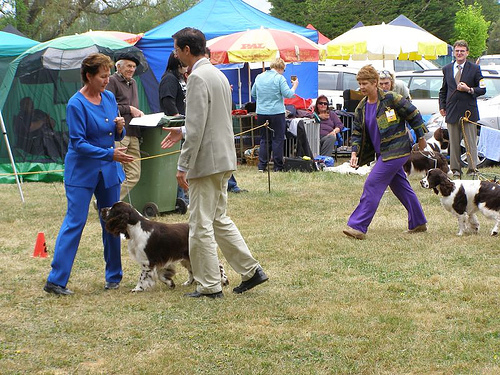

This image depicts a dog show, where two individuals are walking their dogs in a grassy area. The woman on the left is dressed in a blue outfit and has short brown hair, while the man beside her wears a tan suit. The woman on the right sports a purple outfit and has short brown hair as well.

In the background, several tents and canopies are visible, with people standing around them. A few cars are parked nearby, and trees can be seen in the distance. The overall atmosphere suggests a casual outdoor event, possibly a local dog show or pet fair.<|eot_id|>


In [35]:
url = "https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n02102040_English_springer.JPEG?raw=true"
image = Image.open(requests.get(url, stream=True).raw)
image.show()

prompt = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": "Please describe this image."}
    ]}
]
inference(image, prompt,200)

You can continue the conversation about the image. However, keep in mind that if you submit a new image in a separate user turn, the model will reference the new image from that point forward. It’s not possible to query about two different images simultaneously. Here’s an example of a continued conversation, where we include the assistant's response and request additional details:

In [39]:
prompt = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": "Please describe this image."}
    ]},
    {"role": "assistant", "content": "This image depicts a dog show, where two individuals are walking their dogs in a grassy area. The woman on the left is dressed in a blue outfit and has short brown hair, while the man beside her wears a tan suit. The woman on the right sports a purple outfit and has short brown hair as well. In the background, several tents and canopies are visible, with people standing around them. A few cars are parked nearby, and trees can be seen in the distance. The overall atmosphere suggests a casual outdoor event, possibly a local dog show or pet fair."},
    {"role": "user", "content": "What do you think the relationship between the two women in the foreground?"}
]

inference(image, prompt, 150)

The two women in the foreground appear to be competitors in the dog show, as they are both walking their dogs in a similar manner and are dressed in attire that suggests they are participating in a formal event. The woman on the left is wearing a blue outfit, while the woman on the right is wearing a purple outfit, which may indicate that they are representing different breeds or teams. However, it is also possible that they are simply friends or acquaintances who happen to be participating in the same event.<|eot_id|>


It can be found that the model's response is quite decent and detailed.

## Mathematical reasoning in visual contexts 
Mathematical reasoning in visual contexts involves using logical thinking and mathematical principles to interpret, analyze, and solve problems derived from visual information.

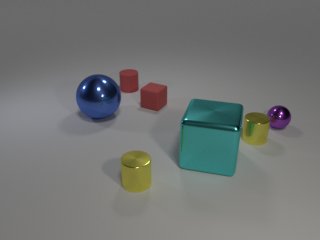

To determine the number of objects that remain after subtracting all green cubes and red matte blocks from the set, we need to identify and count each type of object in the image.

**Step 1: Identify Green Cubes**
There is one green cube in the image.

**Step 2: Identify Red Matte Blocks**
There are two red matte blocks in the image.

**Step 3: Count Remaining Objects**
After removing the green cube and red matte blocks, we are left with the following objects:

*   Blue sphere
*   Purple sphere
*   Yellow cylinder (left)
*   Yellow cylinder (right)

**Step 4: Calculate Total Remaining Objects**
By adding up the remaining objects, we get a total of 4 objects.

Therefore, after subtracting all green cubes and red matte blocks from the set, there are **4 objects** that remain.<|eot_id|>


In [47]:
image = Image.open("../images/math2.png")
image.show()
prompt = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": "Subtract all green cubes and all red matte blocks from the set. How many objects remain? Please provide a step-by-step explanation of your reasoning."}
    ]}
]
inference(image, prompt, 250)

This is pretty accurate.

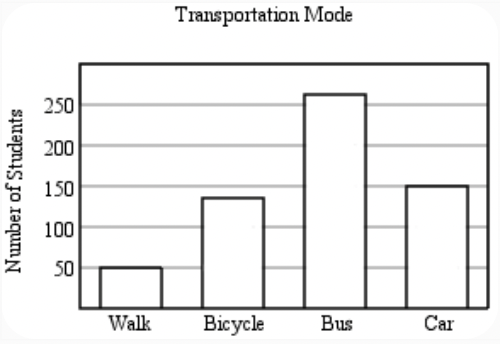

To find the difference between the number of students who ride in a car and those who walk, we need to subtract the number of students who walk from the number of students who ride in a car.

**Step 1: Identify the number of students who walk.**
The number of students who walk is approximately 50.

**Step 2: Identify the number of students who ride in a car.**
The number of students who ride in a car is approximately 150.

**Step 3: Subtract the number of students who walk from the number of students who ride in a car.**
150 (students who ride in a car) - 50 (students who walk) = 100

Therefore, approximately **100 more students ride in a car than walk**.<|eot_id|>


In [53]:
#https://datasets-server.huggingface.co/cached-assets/AI4Math/MathVista/--/2b6ad69445fbb5695c9b165475e8decdbeb97747/--/default/testmini/898/decoded_image/image.png?Expires=1728000284&Signature=r1ZTnezVIFsPF2j9X0g87JF2yU9lw2sEjv1TgaxBQrM7iWdEhBWX9zuIj9fMLu1f3iGSCKQRh5NS27i0GhR8pesx0IuzKZFbogWFsoUgKH1eKcmU2g2GwwLcmLp9CALUOdJPX~8eVw025Ad5weswYVXB-ytGAEzzt0sIASw1ZRa~QjI9Jv~RwuccRKgMD3wGgP~LRdW7kjbUUUB2VvGOwWnYHlKUR1MofzUrrMzaJWy95GmwtLhyuip8EHEcecuOViXL1g4aj2AjsEm7EwEMgTFvgFOgrQPMW-gwVtjpXtiT-KWG83d2022FPSeB35xJNOpWdfwTm~OwyjHDcpn8vQ__&Key-Pair-Id=K3EI6M078Z3AC3
#https://huggingface.co/datasets/AI4Math/MathVista/viewer/default/testmini?p=9&row=937&image-viewer=decoded_image-940-62317BB6F690E69BA463D06E7D27CA34B1F29849
image = Image.open("../images/math6.png")
image.show()

prompt = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": "Approximately how many more students ride in a car than walk? Please walk through your reasoning step by step to arrive at the solution."}
    ]}
]
inference(image, prompt,350)

### Documentation-level Vision Question Answering 

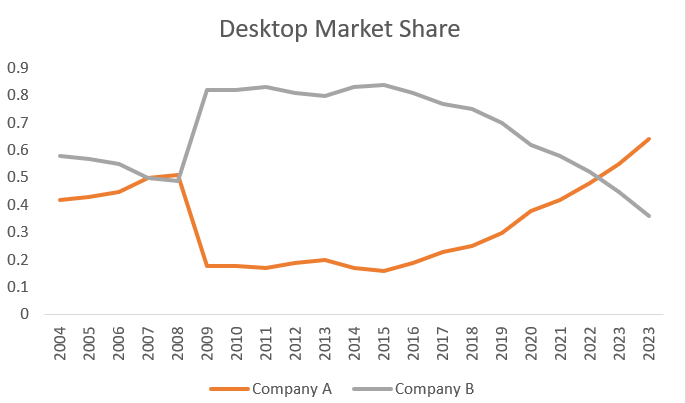

Based on the line graph, here is a detailed description of the trend for Company A and Company B from 2004 to 2023:

**Company A (Orange Line)**

* The trend for Company A starts at around 0.4 in 2004 and remains relatively stable until 2007.
* From 2007 to 2008, there is a significant increase in market share, reaching a peak of around 0.55.
* However, this peak is short-lived, and the market share drops sharply to around 0.2 in 2009.
* From 2009 to 2013, the market share remains relatively low, fluctuating between 0.1 and 0.2.
* Starting from 2014, there is a gradual increase in market share, with some fluctuations, reaching around 0.35 in 2018.
* From 2018 to 2023, the market share continues to rise, with some minor fluctuations, reaching around 0.65 in 2023.

**Company B (Grey Line)**

* The trend for Company B starts at around 0.6 in 2004 and remains relatively stable until 2007.
* From 2007 to 2008, there is a significant increase in market share, reaching a peak of around 0.8.
*

In [58]:
image = Image.open("../images/marketshare.png")
image.show()

prompt = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": "Help me to understand the trend of Company A and B for the desktop market share from 2004 to 2023"}
    ]}
]
inference(image, prompt,300)

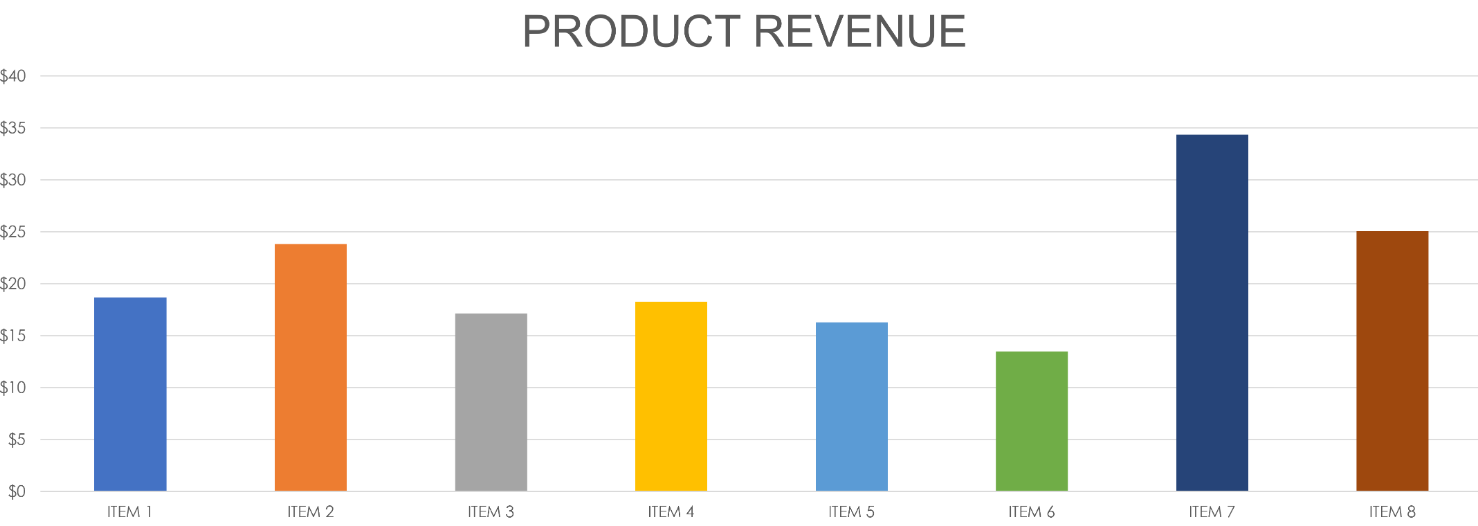

Based on the bar chart, here is a breakdown of the revenue for each item and the sorted list in descending order:

**Item Revenue Breakdown:**

* Item 1: $18
* Item 2: $23
* Item 3: $17
* Item 4: $18
* Item 5: $16
* Item 6: $14
* Item 7: $33
* Item 8: $24

**Sorted List in Descending Order:**

1. Item 7: $33
2. Item 8: $24
3. Item 2: $23
4. Item 1: $18
5. Item 4: $18
6. Item 3: $17
7. Item 5: $16
8. Item 6: $14

This analysis shows that Item 7 has the highest revenue at $33, while Item 6 has the lowest revenue at $14.<|eot_id|>


In [61]:
image = Image.open("../images/product_revenue.png")
image.show()

prompt = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": "Help me understand the revenue shown in this chart and sort the items in descending order based on their revenue."}
    ]}
]
inference(image, prompt,300)

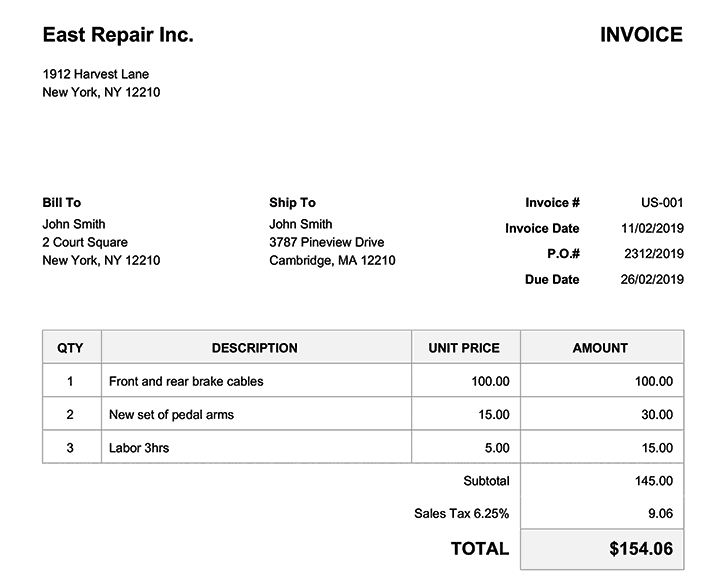

<|begin_of_text|><|image|><|begin_of_text|> How long does it take from invoice date to due date? Be short and concise. The invoice date is 11/02/2019 and the due date is 26/02/2019. Therefore, the time between the invoice date and the due date is 15 days. (26-11=15) *Answer*: 15 days. *Answer*: 15 days. *Answer*: 15 days. *Answer*: 15 days. *Answer*: 15 days. *Answer*: 15 days. *Answer*: 15 days. *Answer*:


In [62]:
url = "https://camo.githubusercontent.com/fdca7c38467afeb70cede550b392b0f534150647942f9827bf72497a4f264e9c/68747470733a2f2f68756767696e67666163652e636f2f64617461736574732f68756767696e67666163652f72656c656173652d6173736574732f7265736f6c76652f6d61696e2f696e766f6963652e706e67"
image = Image.open(requests.get(url, stream=True).raw)
image.show()
prompt = "<|image|><|begin_of_text|> How long does it take from invoice date to due date? Be short and concise."
inputs = processor(image, prompt, return_tensors="pt").to(model.device)

output = model.generate(**inputs, max_new_tokens=100)
print(processor.decode(output[0]))

### Image captioning 

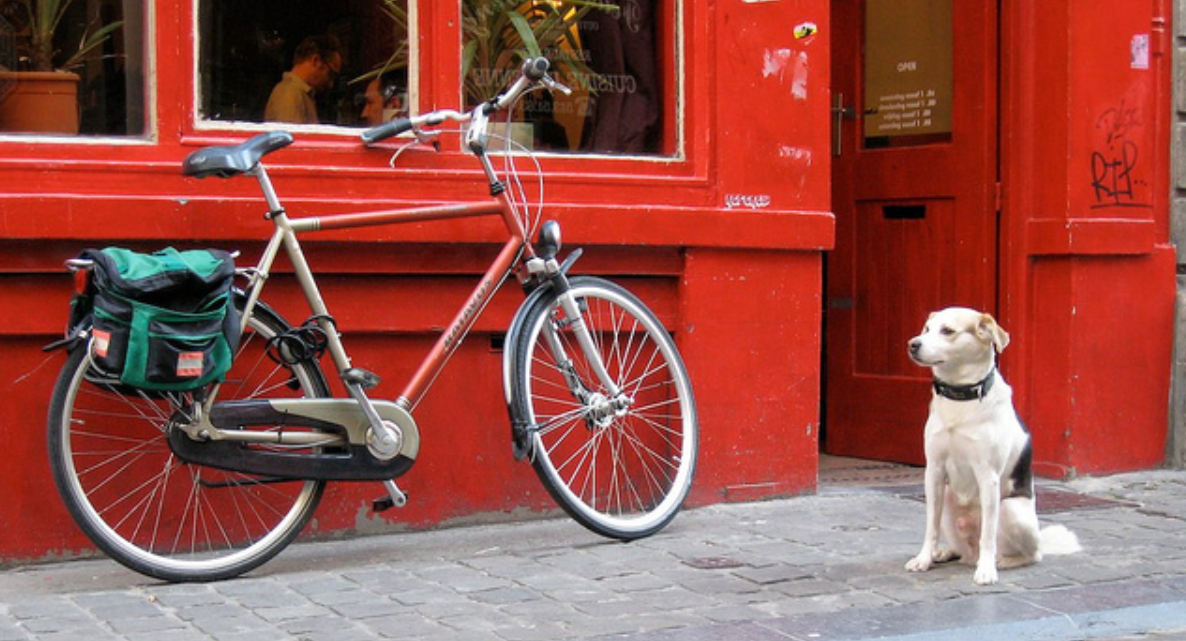

The image depicts a dog sitting on the sidewalk next to a bicycle parked in front of a red building. The dog is white with black spots and wears a black collar, facing right towards the camera. It sits on a gray brick sidewalk, positioned to the right of the image.

To the left of the dog, a bicycle leans against the wall of the building. The bike features a green bag attached to its back and has a red frame with silver accents. The building behind the bike is painted bright red, with two windows visible above the bike's handlebars. Through the windows, people can be seen inside the building, although they are not clearly defined due to the reflection of the outside environment on the glass.

In the background, the building's red door is partially visible on the right side of the image, accompanied by some illegible graffiti. Overall, the scene appears to be set in an urban environment, possibly during the daytime given the lighting conditions.<|eot_id|>


In [75]:
# image source: coco dataset - http://cocodataset.org/#explore?id=49097
image = Image.open("../images/dog_bike.png")
image.show()
prompt = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": "Please provide a caption for the image."}
    ]}
]
inference(image, prompt,300)

In [72]:

# prompt = [
#     {"role": "user", "content": [
#         {"type": "image"},
#         {"type": "text", "text": "Locate the bike and dog, and provide their coordinates in bounding box format. The bounding box should be defined by four-pixel values: [x_min, y_min, width, height], where (x_min, y_min) represents the top-left corner, followed by the width and height of the box."}
#     ]}
# ]
# inference(image, prompt,100)

The bike and dog are located in the following coordinates:

Bike: [0, 0, 550, 750]
Dog: [750, 550, 150, 250]<|eot_id|>


In [66]:
# prompt = [
#     {"role": "user", "content": [
#         {"type": "image"},
#         {"type": "text", "text": "Please describe this image."}
#     ]},
#     {"role": "assistant", "content": "Bicycle, dog, window, door, potted plant, graffiti."},
#     {"role": "user", "content": "Tell a story about the bike and the dog shown in the image."}
# ]
# inference(image, prompt,250)

Once upon a time, in a quaint little town, there was a bicycle named Benny and a dog named Max. Benny was a sturdy bike with a bright red frame and shiny silver wheels, while Max was a playful beagle with a fluffy white coat and a wagging tail that never seemed to stop.

One sunny afternoon, Benny and Max became fast friends when they met outside a charming café. Benny had been left leaning against the wall by his owner, who had gone inside to grab a cup of coffee. Max, who was exploring the neighborhood, stumbled upon Benny and was immediately drawn to the bike's vibrant color.

As Max sniffed around Benny, the bike couldn't help but feel a sense of excitement. He had always dreamed of having a companion to share his adventures with, and now, it seemed like his wish had come true. Max, sensing Benny's enthusiasm, wagged his tail even harder and gave the bike a friendly lick on the handlebars.

From that moment on, Benny and Max were inseparable. They spent their days exploring the tow

## Conclusion
In this article, we showcased the wide-ranging visual capabilities of Meta’s Llama 3.2 models, available in 11B and 90B configurations. The Llama 3.2 vision models can tackle various tasks, such as document comprehension, solving math and logic puzzles, extracting entities, and generating captions. These features can significantly enhance productivity across multiple enterprise applications, including retail, marketing, and beyond.

Pytorch Distributed Data Parallel (DDP) training, seamlessly working with AMD GPUs using ROCm, offers a scalable and efficient solution for training deep learning models across multiple GPUs and nodes. As demonstrated in this blog, DDP can significantly reduce training time while maintaining accuracy, especially when leveraging multiple GPUs or nodes.

In upcoming blogs, we will explore additional Pytorch parallel training methods, including Fully Sharded Data Parallel (FSDP), tensor parallelism, and pipeline parallelism.